In [1]:
import numpy as np
from scipy import ndimage
import cv2 as cv
import math
from matplotlib import pyplot as plt

In [2]:
def drawGrayHist(img, maxValue = 256):
    plt.figure(figsize=(10,5))
    plt.hist(img.ravel(), maxValue, [0,maxValue])
    plt.xlim([0, maxValue])
    plt.grid()
    plt.show()
    return

def drawGrayHistMasked(img, maxValue = 256):
    # create a mask
    height = img.shape[0]
    width = img.shape[1]
    mask = np.zeros(img.shape[:2], np.uint8)
    mask[int(height/4): int(height * 3 / 4), int(width/4): int(width * 3/4)] = 255
    #masked_img = cv.bitwise_and(img, img, mask = mask)
    hist_mask = cv.calcHist([img], [0], mask, [maxValue], [0, maxValue])
    plt.figure(figsize=(10,5))
    plt.plot(hist_mask,color = 'b')
    plt.xlim([0, maxValue])
    plt.grid()
    plt.show()
    

# Polar

In [3]:
img = cv.imread("papka/krygi/lines.png", 0) # Загружаем изображение сразу в Grayscale
#преобразуем в полярную систему координат
polar = cv.linearPolar(img, (img.shape[1]//2 , img.shape[0]//2), img.shape[1]//2,  cv.WARP_FILL_OUTLIERS)
cv.imwrite("results/polar.png", polar)

True

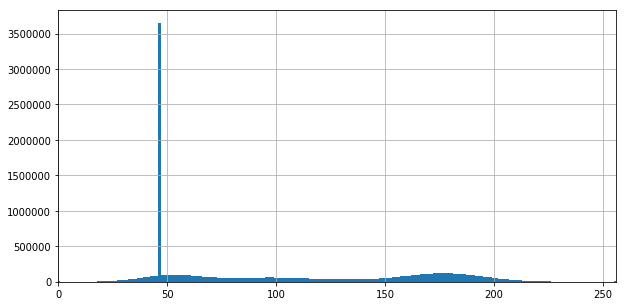

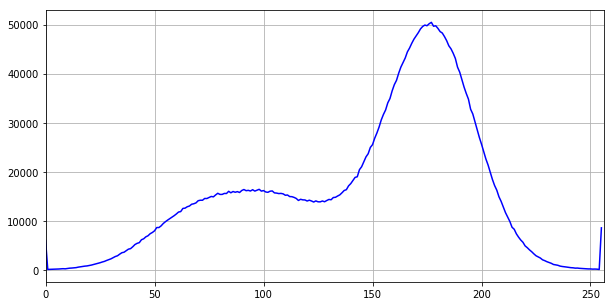

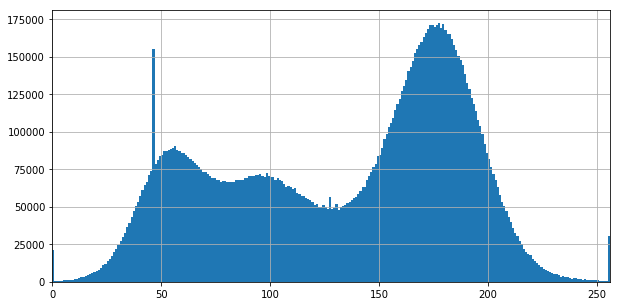

In [4]:

drawGrayHist(img)
drawGrayHistMasked(img)
drawGrayHist(polar)

# Convolution + Abs

In [5]:
kernel = np.array([
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1],
[-1, -1, -1, -1, 2, 2, 2, 2, -1, -1, -1, -1]])
convolved_polar = ndimage.convolve(np.float32(polar),kernel)
cv.imwrite("results/convolved_polar.png",convolved_polar)
abs_polar = np.abs(convolved_polar)
cv.imwrite("results/abs_polar.png",abs_polar)


#FREE CONVOLVED
convolved_polar = None

# Histogram

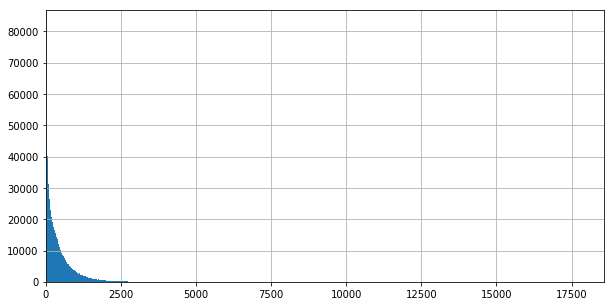

In [6]:
drawGrayHist(abs_polar, int(np.max(abs_polar) + 1))

# Thresholding

In [18]:
#THRESH = 3000
THRESH = np.percentile(abs_polar, 95)
ret,bin_result = cv.threshold(abs_polar, THRESH , 255, cv.THRESH_BINARY)
cv.imwrite("results/bin_result.png",bin_result)
bin_result = np.uint8(bin_result)

In [19]:
print(ret)
print('#####')
print(bin_result)
print(THRESH)

1388.0
#####
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1388.0


# Kernel

In [22]:

my_kernel = np.uint8(np.array([[0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0]]))


# Morph Close

In [23]:
rect_kernel = cv.getStructuringElement(cv.MORPH_RECT,(5, 5))
morph = cv.morphologyEx(bin_result, cv.MORPH_CLOSE, my_kernel)
cv.imwrite("results/morph_close.png", morph)
bin_result = np.uint8(morph)

#FREE MORPH
morph = None

# Morph Open

In [ ]:
rect_kernel = cv.getStructuringElement(cv.MORPH_RECT,(5, 5))
morph = cv.morphologyEx(bin_result, cv.MORPH_OPEN, my_kernel)
cv.imwrite("results/morph_open.png", morph)
bin_result = np.uint8(morph)

In [ ]:
print(bin_result)

# Line Detection

### By accumulative array

In [24]:
print(morph)
AccArray =  (np.sum(bin_result, axis = 0) / 255)
print(AccArray)

None
[1259. 1050.  769. ...    0.    0.    0.]


In [25]:
polar = cv.imread("results/polar.png", 0)
polar = cv.cvtColor(polar, cv.COLOR_GRAY2RGB)
percent = 0.5
for i in range(0, len(AccArray)):
    if ((AccArray[i] / 4000.0) > percent):
        pt1 = (i, 0)
        pt2 = (i, polar.shape[0])
        cv.line(polar, pt1, pt2, (0,0,255), 1)

cv.imwrite("results/AccumulativeArrayDetect.png", polar)

True

In [26]:
print(np.max(AccArray))

2338.0


### By connected components

In [11]:
# You need to choose 4 or 8 for connectivity type
connectivity = 8
# Perform the operation
output = cv.connectedComponentsWithStats(bin_result, connectivity, cv.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

print("Num labels = " + str(num_labels))
print("Labels\n", labels)
print("Stats\n", stats)
print("Centroids\n" , centroids)

Num labels = 18228
Labels
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Stats
 [[       0        0     4000     4000 15116676]
 [       2        0       16      426     3210]
 [      59        0        2       12       21]
 ...
 [    1609     3998        2        2        3]
 [    2373     3999        1        1        1]
 [    2379     3999        1        1        1]]
Centroids
 [[2080.25225519 2005.55532956]
 [   9.83582555  194.05607477]
 [  59.42857143    4.85714286]
 ...
 [1609.33333333 3998.66666667]
 [2373.         3999.        ]
 [2379.         3999.        ]]


In [12]:
lblareas = stats[:,cv.CC_STAT_AREA]
print(lblareas)
print(polar.shape)

[15116676     3210       21 ...        3        1        1]
(4000, 4000)


In [13]:
print(labels.shape[1])
print(lblareas[1:])
print(num_labels)

4000
[3210   21   48 ...    3    1    1]
18228


436
done


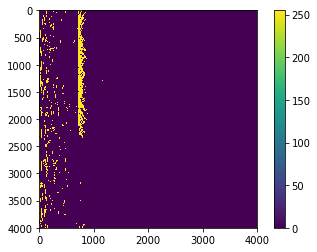

In [14]:
outputImg = np.zeros(labels.shape)
#markedLabels = []
upperBound = int(np.percentile(lblareas[1:], 99))
print(upperBound)
for i in range(1, num_labels):
    if(lblareas[i] >= upperBound) :
        outputImg[labels == i] = 255
        #markedLabels.append(i)

#print(markedLabels)
print("done")

#for i in range(0, labels.shape[0]) :
#    if i % 100 == 0:
#        print(i)
#    for j in range(0, labels.shape[1]) :
#        if labels[i][j] in markedLabels :
#            outputImg[i][j] = 255

#outputImg[labels in markedLabels] = 255
plt.imshow(outputImg)
plt.colorbar()
plt.show()

### By Hough transform

In [ ]:
#HOUGH LINES
lines = cv.HoughLinesP(bin_result, rho = 1, theta = math.pi/2, threshold = 500, minLineLength = 50, maxLineGap = 4)

polar = cv.cvtColor(polar, cv.COLOR_GRAY2RGB)

print(lines.shape)

for line in lines:
    pt1 = (line[0][0],line[0][1])
    pt2 = (line[0][2],line[0][3])
    cv.line(polar, pt1, pt2, (0,0,255), 1)

cv.imwrite("results/hough_result.png", polar)

# Inverse Polar

In [27]:
result = cv.linearPolar(polar, (polar.shape[1]//2 , polar.shape[0]//2), polar.shape[1]//2, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)
cv.imwrite("results/result.png", result)

True

# Hough transform

# Connected Components

In [ ]:
# You need to choose 4 or 8 for connectivity type
connectivity = 4  
# Perform the operation
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

In [ ]:
#new code
# for every component in the output image
for label in range(num_labels):

# retrieving the width of the bounding box of the component
width = stats[label, cv2.CC_STAT_WIDTH]
# retrieving the height of the bounding box of the component
height = stats[label, cv2.CC_STAT_HEIGHT]
# retrieving the leftmost coordinate of the bounding box of the component
x = stats[label, cv2.CC_STAT_LEFT]
# retrieving the topmost coordinate of the bounding box of the component
y = stats[label, cv2.CC_STAT_TOP]

# creating the ROI using indexing
roi = thresh[y:y+height, x:x+width]

# calculating the image moments and Hu moments of the ROI
img_moments = cv2.moments(roi)
hu = cv2.HuMoments(img_moments)

# DEV

In [ ]:
print(lblareas[1:])

In [ ]:


def f(a, b):
    return x * x + 3 * x - 2 if x > 0 else x * 5 + 8

f = np.vectorize(f)  # or use a different name if you want to keep the original f

result_array = f(A)

### Contours

In [ ]:
newpolar = cv.cvtColor(polar, cv.COLOR_GRAY2RGB)
im2, contours, hierarchy = cv.findContours(bin_result, 1, 2)
cv.drawContours(newpolar, contours, -1, (0,255,0), 1)
cv.imwrite("results/contours.png", newpolar)


In [ ]:
print(convolved_polar)

In [ ]:
new_abs_polar = cv.imread("results/convolved_polar.png", 0)
print(new_abs_polar)

In [ ]:
plt.imshow(abs_polar)
plt.colorbar()
plt.show()

In [ ]:
U = np.array([3,6,9])
print(U / 3.0)

In [ ]:
TEMP = np.percentile(abs_polar, 95)
print(TEMP)

In [ ]:
BinImg = cv.imread("experiments/kvadrat.jpg", 0)
THRESH = 30
ret, BinImg = cv.threshold(BinImg, THRESH , 255, cv.THRESH_BINARY)
plt.imshow(BinImg)
plt.colorbar()
plt.show()

In [ ]:
# You need to choose 4 or 8 for connectivity type
connectivity = 8 
# Perform the operation
output = cv.connectedComponentsWithStats(BinImg, connectivity, cv.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

print("Num labels = " + str(num_labels))
print("Labels\n", labels)
print("Stats\n", stats)
print("Centroids\n" , centroids)

In [ ]:
lblareas = stats[1:,cv.CC_STAT_AREA]
print(lblareas)


In [ ]:
contours = cv.findContours(BinImg, 1, 2)[0]
max_area = 0
max_contour_index = 0
for i, contour in enumerate(contours):
    contour_area = cv.moments(contour)['m00']
    if contour_area > max_area:
        max_area = contour_area
        max_contour_index = i
newImg = np.zeros(BinImg.shape, dtype=np.uint8)
cv.drawContours(newImg, contours, max_contour_index, color=255, thickness=-1)
cv.imwrite("experiments/out.png", newImg)

In [ ]:
print(newImg.shape)

In [3]:
x = np.array([1,2,3,4,5])
index = np.argwhere(x==3)
y = np.delete(x, index)
print(x, y)

[1 2 3 4 5] [1 2 4 5]


In [43]:
s = 0

In [44]:
for i in range(0, 70):
    s += i **2
print(s)

111895
